In [22]:
from game_of_life import Game_of_life
from models.autoencoder import ConvolutionalAutoencoder
from models.fullycon import CullyConnCoder
from matplotlib import pyplot as plt

import torch.nn as nn
import torch
import tqdm
import numpy as np
import torch.optim as optim

%load_ext autoreload
%autoreload 2

device = "cuda" if torch.cuda.is_available() else "cpu"

SIZE=16

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
mask = torch.ones((1, SIZE, SIZE)).to(device)

In [24]:
from deepq_utils import ReplayMemory, Transition

def optimize_model(policy_net: torch.nn.Module, target_net: torch.nn.Module, memory: ReplayMemory, optimizer: torch.optim.Optimizer, BATCH_SIZE: int, GAMMA: int, mask:torch.tensor):
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    next_state_batch = torch.cat(batch.next_state)
    # print(state_batch.shape)
    # print(action_batch.shape)
    # print(reward_batch.shape)
    # print(next_state_batch.shape)


    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = torch.amax(policy_net.place(state_batch, mask) * action_batch, dim=(1,2,3))
    # print(state_action_values.shape)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    with torch.no_grad():
        next_state_values = torch.amax(target_net.place(next_state_batch, mask), dim=(1,2,3)).to(device)
        # print(next_state_values.shape)
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch
    # print(reward_batch.shape)
    # print(next_state_values.shape)
    # print(expected_state_action_values.shape)

    # Compute Huber loss
    criterion = nn.HuberLoss()
    # criterion = nn.MSELoss()
    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 10)
    optimizer.step()

In [25]:
from plotting import plot_state

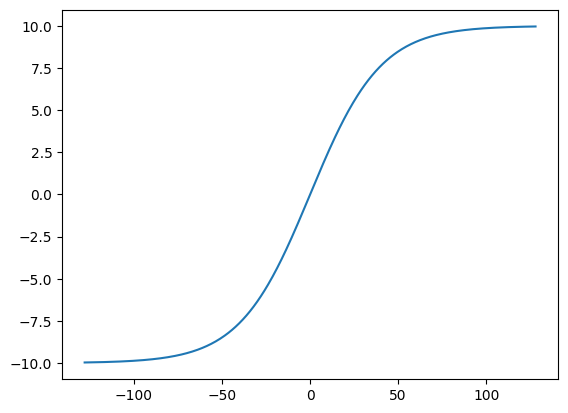

In [26]:
reward_samples = np.linspace(-128, 128, 500)
out = torch.nn.functional.sigmoid(torch.from_numpy(reward_samples)/20).numpy()*20-10
plt.plot(reward_samples, out)
plt.show()

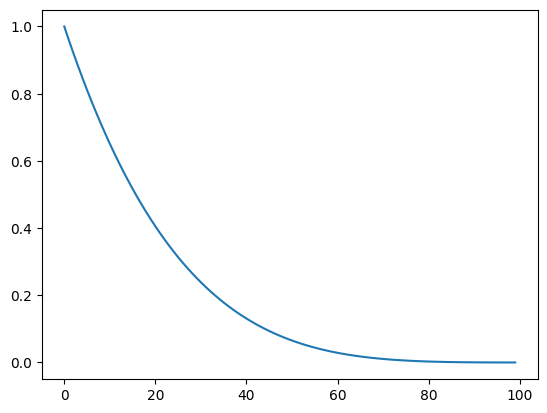

In [27]:
def generate_eps(num_episodes:int)->np.ndarray:
  return np.power(np.linspace(1.0, 0.1, num_episodes), 4.5)

data = generate_eps(100)
plt.plot(data)
plt.show()

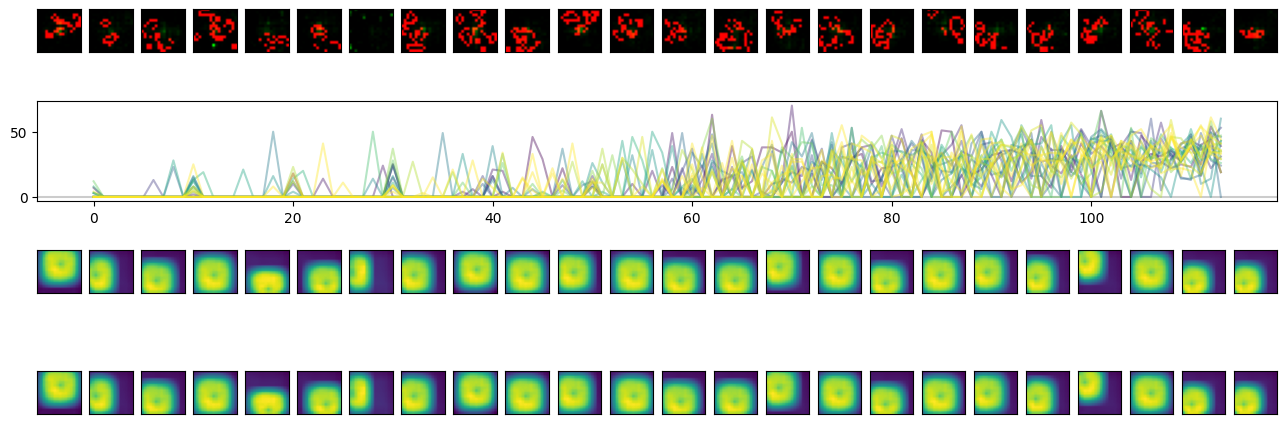

[[[ 31.674728  64.270676  91.47161  141.9013   184.12267  228.24405
   260.31195  276.8679   277.08377  273.22998  274.82242  282.2028
   265.55655  245.76588  198.82094  137.55562 ]
  [ 37.41922   83.86996  117.37931  178.06569  218.823    252.31676
   274.9015   274.20172  272.708    253.49887  273.83966  290.6951
   290.52026  278.59933  244.47514  187.1772  ]
  [ 39.34603   96.23923  132.3271   194.27844  233.48576  265.08884
   286.5138   295.11288  291.6181   279.32455  285.2491   301.01007
   304.85727  292.38123  264.21902  209.27177 ]
  [ 38.844746 102.10421  144.4074   206.94923  249.61568  281.8083
   299.64603  307.77832  302.47034  289.30942  296.29822  309.35443
   315.9504   302.69308  277.03528  219.60976 ]
  [ 38.505325 101.64843  149.86507  210.2643   252.19539  285.99683
   304.49554  325.2662   322.06067  321.7925   319.9606   327.90268
   324.8813   309.6101   279.872    219.19655 ]
  [ 38.26814   96.529396 149.0093   206.44829  246.68445  276.6601
   295.70654  31

In [28]:
import math
# from models.simpLEnet import SimLEnet
from models.resnet import KaoResnet
from deepq_utils import GameEnv, select_action

BATCH_SIZE = 24
TRAIN_BATCH_SIZE = 200
GAMMA = 0.9
TAU = 0.1
LR = 1e-3
num_episodes = 200
EPS = generate_eps(num_episodes)

policy_net = KaoResnet(SIZE).to(device)
target_net = KaoResnet(SIZE).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(1000)

rewards = []

for i_episode in range(num_episodes):
    env = GameEnv(size=SIZE, batch_size=BATCH_SIZE, mask=mask)
    # Initialize the environment and get its state
    actions  = torch.zeros_like(env.state, dtype=torch.float) # visualization only
    state = env.state

    if( i_episode % 10 == 0):
        print("VALIDATION")
        eps = 0
    else:
        eps = EPS[i_episode]

    for t in range(120):
        for i in range(4):
            action = select_action(state, eps, policy_net, mask)
            actions += action.float()
            next_state, reward = env.step(action)
            # Store the transition in memory
            memory.push(state, action, next_state, reward)
            # Move to the next state
            state = next_state
    
        # Perform one step of the optimization (on the policy network)
        optimize_model(
            policy_net=policy_net,
            target_net=target_net,
            memory=memory,
            optimizer=optimizer,
            BATCH_SIZE=TRAIN_BATCH_SIZE,
            GAMMA=GAMMA,
            mask=mask
        )

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)
    
    with torch.no_grad():
        target_model_preds = target_net.place(action, mask).cpu().numpy()
        policy_model_preds = policy_net.place(action, mask).cpu().numpy()
        print(target_model_preds[0])
    
    env.reset()
    rw = reward.sum(dim=(1)).cpu().numpy()
    rewards.append(reward.sum(dim=(1)).cpu().numpy())
    print(i_episode, eps, rw)
    plot_state(state, actions, rewards, None, target_model_preds, policy_model_preds)